In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
pca.components_.T[:, 0]

array([-0.93636116, -0.29854881, -0.18465208])

In [7]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [10]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components=0.95)
X_reduces = pca.fit_transform(X_train)

In [12]:
d

154

In [13]:
X_reduces.shape, X_train.shape

((52500, 154), (52500, 784))

In [14]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [15]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


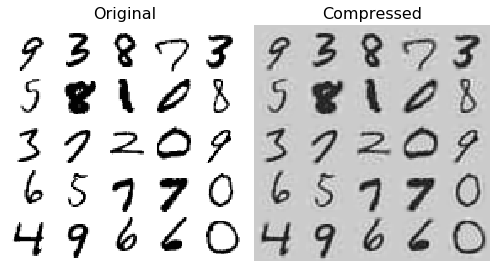

In [16]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [18]:
%%time
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

CPU times: user 27.6 s, sys: 1.02 s, total: 28.7 s
Wall time: 16.8 s


In [19]:
%%time
rnd_pca = PCA(n_components=154, svd_solver="full")
X_reduced = rnd_pca.fit_transform(X_train)

CPU times: user 40.8 s, sys: 439 ms, total: 41.2 s
Wall time: 24.9 s


In [20]:
%%time
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

CPU times: user 1min 38s, sys: 2.16 s, total: 1min 40s
Wall time: 1min 6s


In [21]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [22]:
del X_mm

In [23]:
%%time
X_mm = np.memmap(filename,
                 dtype="float32",
                 mode="readonly",
                 shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154,
                         batch_size=batch_size)
inc_pca.fit(X_mm)

CPU times: user 1min 34s, sys: 1.36 s, total: 1min 35s
Wall time: 55.9 s


IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [25]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components=2,
                    kernel="rbf",
                    gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

y = t > 6.9

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=2)
grid_search.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] kpca__gamma=0.03, kpca__kernel=rbf ..............................
[CV] ............... kpca__gamma=0.03, kpca__kernel=rbf, total=   0.1s
[CV] kpca__gamma=0.03, kpca__kernel=rbf ..............................
[CV] ............... kpca__gamma=0.03, kpca__kernel=rbf, total=   0.1s
[CV] kpca__gamma=0.03, kpca__kernel=rbf ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............... kpca__gamma=0.03, kpca__kernel=rbf, total=   0.1s
[CV] kpca__gamma=0.03, kpca__kernel=sigmoid ..........................
[CV] ........... kpca__gamma=0.03, kpca__kernel=sigmoid, total=   0.1s
[CV] kpca__gamma=0.03, kpca__kernel=sigmoid ..........................
[CV] ........... kpca__gamma=0.03, kpca__kernel=sigmoid, total=   0.0s
[CV] kpca__gamma=0.03, kpca__kernel=sigmoid ..........................
[CV] ........... kpca__gamma=0.03, kpca__kernel=sigmoid, total=   0.1s
[CV] kpca__gamma=0.03222222222222222, kpca__kernel=rbf ...............
[CV]  kpca__gamma=0.03222222222222222, kpca__kernel=rbf, total=   0.1s
[CV] kpca__gamma=0.03222222222222222, kpca__kernel=rbf ...............
[CV]  kpca__gamma=0.03222222222222222, kpca__kernel=rbf, total=   0.1s
[CV] kpca__gamma=0.03222222222222222, kpca__kernel=rbf ...............
[CV]  kpca__gamma=0.03222222222222222, kpca__kernel=rbf, total=   0.1s
[CV] kpca__gamma=0.03222222222222222, kpca__kernel=sigmoid ...........
[CV]  

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [29]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [31]:
rbf_pca = KernelPCA(n_components=2,
                    kernel="rbf",
                    gamma=0.4333,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [32]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

41.67807992297648

In [34]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2,
                             n_neighbors=10)
X_reduced = lle.fit_transform(X)